<a href="https://colab.research.google.com/github/kumarbirendra/ai-ml-analysis/blob/master/INFY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import finance API and get historical stock data
# Source from  https://github.com/dataquestio/project-walkthroughs/blob/master/stock/StockProject.ipynb
!pip3 install yfinance
import yfinance as yf
import os
import json
import pandas as pd


infy = yf.Ticker("INFY.NS")
infy_hist = infy.history(period="max")

infy_hist

In [ ]:
infy_hist.head(5)

In [ ]:
infy_hist.plot.line(y="Close", use_index=True)

In [6]:
data = infy_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})

In [8]:
data["Target"] = infy_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

In [9]:
data

,Actual_Close,Target
Date,,
1996-01-01 00:00:00+05:30,0.538948,NaN
1996-01-02 00:00:00+05:30,0.536768,0.0
1996-01-03 00:00:00+05:30,0.540402,1.0
1996-01-04 00:00:00+05:30,0.536834,0.0
1996-01-05 00:00:00+05:30,0.530491,0.0
...,...,...
2022-10-17 00:00:00+05:30,1489.949951,1.0
2022-10-18 00:00:00+05:30,1503.699951,1.0
2022-10-19 00:00:00+05:30,1485.449951,0.0


In [ ]:
infy_prev = infy_hist.copy()
infy_prev = infy_prev.shift(1)
infy_prev

In [11]:
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(infy_prev[predictors]).iloc[1:]
data

,Actual_Close,Target,Close,Volume,Open,High,Low
Date,,,,,,,
1996-01-02 00:00:00+05:30,0.536768,0.0,0.538948,204800.0,0.537758,0.538948,0.535116
1996-01-03 00:00:00+05:30,0.540402,1.0,0.536768,204800.0,0.537759,0.540402,0.536768
1996-01-04 00:00:00+05:30,0.536834,0.0,0.540402,102400.0,0.540402,0.540402,0.540402
1996-01-05 00:00:00+05:30,0.530491,0.0,0.536834,307200.0,0.535116,0.537759,0.535116
1996-01-08 00:00:00+05:30,0.533795,1.0,0.530491,51200.0,0.530491,0.530491,0.530491
...,...,...,...,...,...,...,...
2022-10-17 00:00:00+05:30,1489.949951,1.0,1474.250000,14990688.0,1485.000000,1494.000000,1467.250000
2022-10-18 00:00:00+05:30,1503.699951,1.0,1489.949951,4286396.0,1476.900024,1495.000000,1475.500000
2022-10-19 00:00:00+05:30,1485.449951,0.0,1503.699951,4692004.0,1510.000000,1510.949951,1497.250000


In [12]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

In [13]:
from sklearn.metrics import precision_score


preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5306122448979592

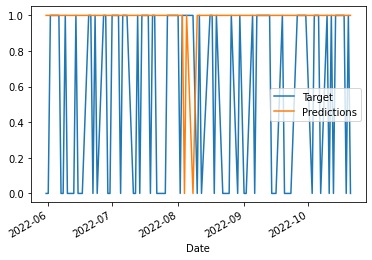

In [14]:
combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()

In [15]:
def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        
        # Fit the random forest model
        model.fit(train[predictors], train["Target"])
        
        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0
        
        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
        
        predictions.append(combined)
    
    return pd.concat(predictions)

In [16]:
predictions = backtest(data, model, predictors)

In [17]:
predictions["Predictions"].value_counts()

0.0    5508
1.0     236
Name: Predictions, dtype: int64

In [18]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5508474576271186

In [19]:
weekly_mean = data.rolling(7).mean()
quarterly_mean = data.rolling(90).mean()
annual_mean = data.rolling(365).mean()
weekly_trend = data.shift(1).rolling(7).mean()["Target"]

In [20]:
data["weekly_mean"] = weekly_mean["Close"] / data["Close"]
data["quarterly_mean"] = quarterly_mean["Close"] / data["Close"]
data["annual_mean"] = annual_mean["Close"] / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]
data["weekly_trend"] = weekly_trend

data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

In [21]:
full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio", "weekly_trend"]
predictions = backtest(data.iloc[365:], model, full_predictors)

In [22]:
precision_score(predictions["Target"], predictions["Predictions"])

0.4870967741935484

In [23]:
predictions["Predictions"].value_counts()

0.0    5069
1.0     310
Name: Predictions, dtype: int64

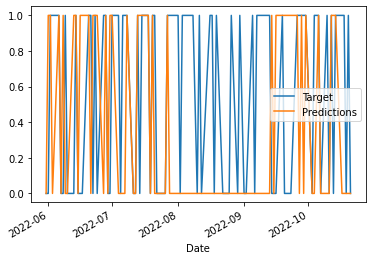

In [24]:
predictions.iloc[-100:].plot()